In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from typing import *
import numpy as np
from functools import partial
from fastprogress import progress_bar
import pandas as pd
import h5py

from lumin.plotting.results import plot_roc

import torch
from torch import Tensor, nn
import torch.nn.functional as F
from torch._vmap_internals import _vmap as vmap

from tomopt.volume import *
from tomopt.muon import *
from tomopt.inference import *
from tomopt.optimisation import *
from tomopt.core import *
from tomopt.utils import *
from tomopt.plotting import *

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
DEVICE = torch.device("cpu")

In [4]:
NAME = 'central_above'

In [5]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)

In [6]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.9
    init_res = 1e4
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,1-(i*(2*size)/n_panels)], init_xy_span=[1.,1.],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,0.2-(i*(2*size)/n_panels)], init_xy_span=[1.,1.],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [19]:
volume = Volume(get_layers())

In [20]:
volume.get_cost()

tensor(8., grad_fn=<AddBackward0>)

In [21]:
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([1., 1.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([1., 1.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([1., 1.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([1., 1.])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.2000]),

# Volume classifier

# Optimisation

In [10]:
from tomopt.optimisation import ULorryPassiveGenerator

In [22]:
u_volume = 12
passive_gen = ULorryPassiveGenerator(volume, u_volume=u_volume, u_prob=0.5, fill_frac=0.8, x0_lorry=X0['iron'], bkg_materials=['air', 'iron'])
trn_passives = PassiveYielder(passive_gen, n_passives=1)

In [23]:
from tomopt.optimisation import NoMoreNaNs, PanelMetricLogger, CostCoefWarmup, PanelOptConfig, MuonResampler

In [24]:
volume.get_cost()

tensor(8., grad_fn=<AddBackward0>)

In [25]:
wrapper = PanelVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=1e-1),
                             z_pos_opt=partial(torch.optim.SGD, lr=1e-1),
                             xy_span_opt=partial(torch.optim.SGD, lr=1e2),
                             loss_func=VolumeClassLoss(x02id={0:0, 1:1}, target_budget=5, cost_coef=0.002, steep_budget=True),
                             partial_volume_inferer=partial(DenseBlockClassifierFromX0s, n_block_voxels=u_volume, partial_x0_inferer=PanelX0Inferer, volume=volume, ratio_offset=-1, ratio_coef=1))

## Initial performance

In [17]:
test_passives = PassiveYielder(passive_gen, n_passives=200)

In [18]:
preds = wrapper.predict(test_passives,
                n_mu_per_volume=250,
                mu_bs=250,
                pred_cb=ClassPredHandler(x02id={0:0, 1:1}),
                cbs=[MuonResampler()])

/home/centos/volume/mode_muon_tomography/tomopt/inference/scattering.py:329: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  idxs = torch.combinations(torch.arange(0, unc.shape[-1]), with_replacement=True)


In [19]:
df_start = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])

<ipython-input-19-9804e60ffd94>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_start = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])


In [20]:
df_start['gen_target'] = df_start.gen_target.astype(int)

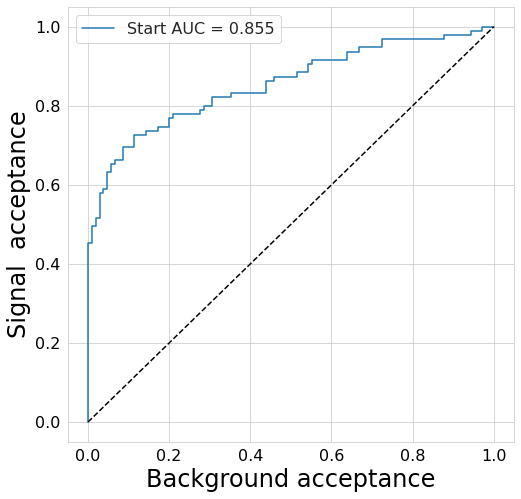

{'Start': 0.8546365914786967}

In [21]:
plot_roc(df_start, labels=['Start'])

## Optimise

In [26]:
from tomopt.optimisation.callbacks.callback import Callback

class GradClip(Callback):
    def __init__(self, clip:float, clip_norm:bool=True):
        super().__init__()
        self.clip = clip
        self.func = nn.utils.clip_grad_norm_ if clip_norm else nn.utils.clip_grad_value_
        
    def on_backwards_end(self) -> None:
        if self.clip > 0: self.func(self.wrapper.parameters(), self.clip)

CostCoefWarmup: Freezing optimisation for 5 epochs
PanelOptConfig: Freezing optimisation for 5 epochs


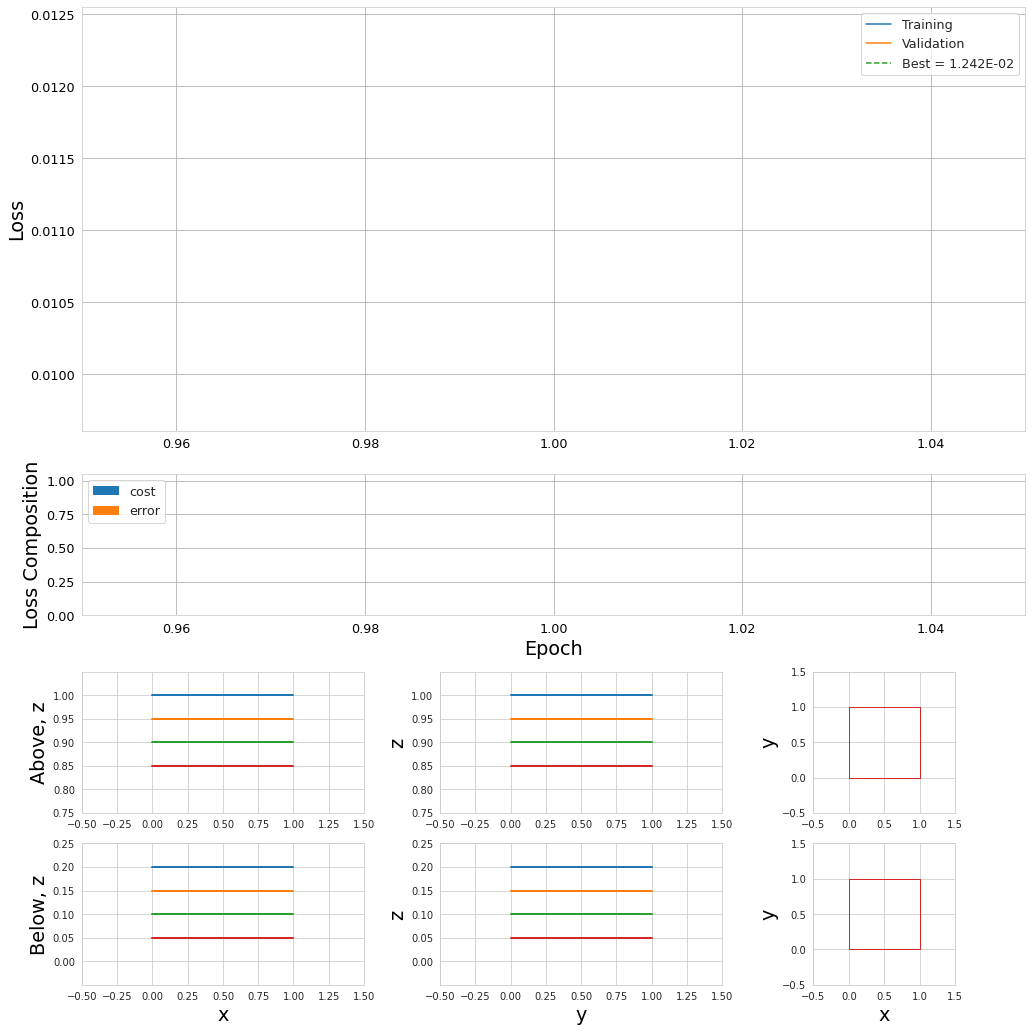

/home/centos/volume/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:211: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fb282998040> (for post_execute):


KeyboardInterrupt: 

In [27]:
_ = wrapper.fit(n_epochs=120,
                passive_bs=1,
                n_mu_per_volume=250,
                mu_bs=250,
                trn_passives=trn_passives,
                val_passives=trn_passives,
                cbs=[
                    CostCoefWarmup(n_warmup=5), PanelOptConfig(n_warmup=5, xy_pos_rate=0.05, z_pos_rate=0.001, xy_span_rate=0.05),
                    MuonResampler(), NoMoreNaNs(), PanelMetricLogger()])

In [ ]:
wrapper.save(f'may_demo/{NAME}_0.pt')

In [ ]:
volume.get_cost()

## Optimised performance

In [ ]:
preds = wrapper.predict(test_passives,
                n_mu_per_volume=250,
                mu_bs=250,
                pred_cb=ClassPredHandler(x02id={0:0, 1:1}),
                cbs=[MuonResampler()])

In [ ]:
df_opt = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])

In [ ]:
df_opt['gen_target'] = df_opt.gen_target.astype(int)

In [ ]:
plot_roc((df_start, df_opt), labels=['Start', 'Optimised'])